In [1]:
!pip3 install -q tqdm 

In [2]:
!pip3 install -q imgaug

In [3]:
import random
import math
import json
from imgaug import augmenters as iaa
from tqdm import tqdm 
import glob
from google.colab import files
from google.colab import drive
import time
import datetime
from datetime import date
import os, sys, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import itertools
import scipy
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor

np.random.seed(123)
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Install Kaggle API to download competition data
# https://www.kaggle.com/general/74235

!pip3 install -q kaggle

!pip3 install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=149d1347369b168bdbe94e9447419f87dabe1e50298c5f7a2c969234e8e2e4db
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [5]:
!ls

sample_data


In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mindyjen","key":"d93d23dee9c18e05d21517d0fadb8efa"}'}

In [7]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-21 06:23:33           5874        535  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3268        284  0.9375           
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1160        103  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset             

In [8]:
# enter your Kaggle credentials here
os.environ['KAGGLE_USERNAME']="mindyjen"
os.environ['KAGGLE_KEY']="d93d23dee9c18e05d21517d0fadb8efa"

In [9]:
# directory of the project
drive.mount('/content/gdrive')
!mkdir /content/gdrive/My\ Drive/Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

Mounted at /content/gdrive
mkdir: cannot create directory ‘/content/gdrive/My Drive/Kaggle’: File exists


In [10]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [11]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:50<00:00, 64.7MB/s]
100% 2.29G/2.29G [00:50<00:00, 49.0MB/s]


In [12]:
!ls
!rm -rf chest_xray/

chest_xray  chest-xray-pneumonia.zip


In [13]:
!ls

chest-xray-pneumonia.zip


In [14]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [15]:
# Root directory of the project
ROOT_DIR = os.path.abspath('/content/gdrive/My Drive/Kaggle')

In [16]:
os.chdir(ROOT_DIR)
!ls

chest_xray


In [17]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'chest_xray')
os.chdir(MODEL_DIR)
!pwd
!ls

/content/gdrive/My Drive/Kaggle/chest_xray
chest_xray  __MACOSX  test  train  val


In [18]:
# Load the images; be sure to also preprocess these into tensors 
data_pneumonia_dir = '/content/gdrive/My Drive/Kaggle/chest_xray/data/PNEUMONIA'
data_normal_dir = '/content/gdrive/My Drive/Kaggle/chest_xray/data/NORMAL'
new_dir = '/content/gdrive/My Drive/Kaggle/chest_xray/split'
DATA_DIR = os.path.join(MODEL_DIR, 'split')

if not os.path.exists(data_pneumonia_dir):
  os.makedirs(data_pneumonia_dir)

if not os.path.exists(data_normal_dir):
  os.makedirs(data_normal_dir)

if not os.path.exists(new_dir):
  os.makedirs(new_dir)

!ls

chest_xray  data  __MACOSX  split  test  train	val


In [19]:
train_folder = os.path.join(MODEL_DIR, 'train')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
train_normal = os.path.join(train_folder, 'NORMAL')

test_folder = os.path.join(MODEL_DIR, 'test')
test_pneumonia = os.path.join(test_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, 'NORMAL')

val_folder = os.path.join(MODEL_DIR, 'val')
val_pneumonia = os.path.join(val_folder, 'PNEUMONIA')
val_normal = os.path.join(val_folder, 'NORMAL')

In [20]:
train_pneumonia

'/content/gdrive/My Drive/Kaggle/chest_xray/train/PNEUMONIA'

In [21]:
imgs_train_pneumonia = [file for file in os.listdir(train_pneumonia) if file.endswith('.jpeg')]
print('There are', len(imgs_train_pneumonia), ' PNEUMONIA images for Training')

There are 3875  PNEUMONIA images for Training


In [22]:
imgs_test_pneumonia = [file for file in os.listdir(test_pneumonia) if file.endswith('.jpeg')]
print('There are', len(imgs_test_pneumonia), ' PNEUMONIA images for Testing')

There are 390  PNEUMONIA images for Testing


In [23]:
imgs_val_pneumonia = [file for file in os.listdir(val_pneumonia) if file.endswith('.jpeg')]
print('There are', len(imgs_val_pneumonia), ' PNEUMONIA images for Validating')

There are 8  PNEUMONIA images for Validating


In [24]:
imgs_train_normal = [file for file in os.listdir(train_normal) if file.endswith('.jpeg')]
print('There are', len(imgs_train_normal), ' NORMAL images for Training')

There are 1341  NORMAL images for Training


In [25]:
imgs_test_normal = [file for file in os.listdir(test_normal) if file.endswith('.jpeg')]
print('There are', len(imgs_test_normal), ' NORMAL images for Testing')

There are 234  NORMAL images for Testing


In [26]:
imgs_val_normal = [file for file in os.listdir(val_normal) if file.endswith('.jpeg')]
print('There are', len(imgs_val_normal), ' NORMAL images for Validating')

There are 8  NORMAL images for Validating


In [27]:
!mv /content/gdrive/My\ Drive/Kaggle/chest_xray/train/PNEUMONIA/*.jpeg /content/gdrive/My\ Drive/Kaggle/chest_xray/data/PNEUMONIA
!mv /content/gdrive/My\ Drive/Kaggle/chest_xray/test/PNEUMONIA/*.jpeg /content/gdrive/My\ Drive/Kaggle/chest_xray/data/PNEUMONIA
!mv /content/gdrive/My\ Drive/Kaggle/chest_xray/val/PNEUMONIA/*.jpeg /content/gdrive/My\ Drive/Kaggle/chest_xray/data/PNEUMONIA

!mv /content/gdrive/My\ Drive/Kaggle/chest_xray/train/NORMAL/*.jpeg /content/gdrive/My\ Drive/Kaggle/chest_xray/data/NORMAL
!mv /content/gdrive/My\ Drive/Kaggle/chest_xray/test/NORMAL/*.jpeg /content/gdrive/My\ Drive/Kaggle/chest_xray/data/NORMAL
!mv /content/gdrive/My\ Drive/Kaggle/chest_xray/val/NORMAL/*.jpeg /content/gdrive/My\ Drive/Kaggle/chest_xray/data/NORMAL

In [32]:
print(os.listdir(train_pneumonia))
print(os.listdir(train_normal))
print(os.listdir(test_pneumonia))
print(os.listdir(test_normal))
print(os.listdir(val_pneumonia))
print(os.listdir(val_normal))

os.removedirs(train_pneumonia)
os.removedirs(train_normal)
os.removedirs(test_pneumonia)
os.removedirs(test_normal)
os.removedirs(val_pneumonia)
os.removedirs(val_normal)

os.chdir(MODEL_DIR)
!ls

chest_xray  data  __MACOSX  split


In [33]:
imgs_pneumonia = [file for file in os.listdir(data_pneumonia_dir) if file.endswith('.jpeg')]
print('There are', len(imgs_pneumonia), ' PNEUMONIA images')

imgs_normal = [file for file in os.listdir(data_normal_dir) if file.endswith('.jpeg')]
print('There are', len(imgs_normal), ' NORMAL images')

There are 4273  PNEUMONIA images
There are 1583  NORMAL images


In [34]:
splitted_train_folder = os.path.join(DATA_DIR, 'train')
splitted_train_pneumonia = os.path.join(splitted_train_folder, 'PNEUMONIA')
splitted_train_normal = os.path.join(splitted_train_folder, 'NORMAL')

splitted_test_folder = os.path.join(DATA_DIR, 'test')
splitted_test_pneumonia = os.path.join(splitted_test_folder, 'PNEUMONIA')
splitted_test_normal = os.path.join(splitted_test_folder, 'NORMAL')

splitted_val_folder = os.path.join(DATA_DIR, 'val')
splitted_val_pneumonia = os.path.join(splitted_val_folder, 'PNEUMONIA')
splitted_val_normal = os.path.join(splitted_val_folder, 'NORMAL')

In [35]:
# training folder    
if os.path.isdir(splitted_train_folder) == False:
    os.mkdir(splitted_train_folder)
if os.path.isdir(splitted_train_pneumonia) == False:
    os.mkdir(splitted_train_pneumonia)
if os.path.isdir(splitted_train_normal) == False:
    os.mkdir(splitted_train_normal)

# testing folder
if os.path.isdir(splitted_test_folder) == False:
    os.mkdir(splitted_test_folder)
if os.path.isdir(splitted_test_pneumonia) == False:
    os.mkdir(splitted_test_pneumonia)
if os.path.isdir(splitted_test_normal) == False:
    os.mkdir(splitted_test_normal)

# validating folder
if os.path.isdir(splitted_val_folder) == False:
    os.mkdir(splitted_val_folder)
if os.path.isdir(splitted_val_pneumonia) == False:
    os.mkdir(splitted_val_pneumonia)
if os.path.isdir(splitted_val_normal) == False:  
    os.mkdir(splitted_val_normal)

In [36]:
# training data of pneumonia
imgs = imgs_pneumonia[:3418]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(splitted_train_pneumonia, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

In [37]:
# training data of normal
imgs = imgs_normal[:1267]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(splitted_train_normal, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

In [38]:
# testing data of pneumonia
imgs = imgs_pneumonia[3418:3845]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(splitted_test_pneumonia, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

In [39]:
# testing data of normal
imgs = imgs_normal[1267:1425]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(splitted_test_normal, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

In [40]:
# validating data of pneumonia
imgs = imgs_pneumonia[3845:4273]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(splitted_val_pneumonia, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

In [41]:
# validating data of normal
imgs = imgs_normal[1425:1583]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(splitted_val_normal, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

In [42]:
imgs = imgs_normal[1425:1583]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(splitted_val_normal, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

In [ ]:
print(os.listdir(data_pneumonia_dir))
print(os.listdir(data_normal_dir))

In [45]:
!rm -f /content/gdrive/My\ Drive/Kaggle/chest_xray/data/PNEUMONIA/*.jpeg
!rm -f /content/gdrive/My\ Drive/Kaggle/chest_xray/data/NORMAL/*.jpeg

In [46]:
os.removedirs(data_pneumonia_dir)
os.removedirs(data_normal_dir)

os.chdir(MODEL_DIR)
!ls

chest_xray  __MACOSX  split


In [47]:
# get all the data in the directory split/train and reshape them
print('training data:')
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    # This is the target directory
    splitted_train_folder, 
    # All images will be resized to 150x150
    target_size=(150, 150), batch_size = 4685)
    #, 
    # Since we use binary_crossentropy loss, we need binary labels
    #class_mode='binary')

training data:
Found 4685 images belonging to 2 classes.


In [49]:
# get all the data in the directory split/validation and reshape them
print('validating data:')
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    splitted_val_folder, 
    target_size=(150, 150), batch_size = 586)
    #,
    #class_mode='binary')

validating data:
Found 586 images belonging to 2 classes.


In [51]:
# get all the data in the directory split/test and reshape them
print('testing data:')
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    splitted_test_folder, 
    target_size=(150, 150), batch_size = 585)
    #,
    #class_mode='binary')

testing data:
Found 585 images belonging to 2 classes.


In [52]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [53]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("*******************************************")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("*******************************************")
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("*******************************************")
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("*******************************************")

Number of training samples: 4685
Number of testing samples: 585
Number of validation samples: 586
*******************************************
train_images shape: (4685, 150, 150, 3)
train_labels shape: (4685, 2)
*******************************************
test_images shape: (585, 150, 150, 3)
test_labels shape: (585, 2)
*******************************************
val_images shape: (586, 150, 150, 3)
val_labels shape: (586, 2)
*******************************************


In [54]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4685, 67500)
(585, 67500)
(586, 67500)


In [55]:
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(4685, 2)
(585, 2)
(586, 2)


In [56]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [57]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [58]:
train_y = np.reshape(train_labels[:,0], (train_labels.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_labels.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_labels.shape[0],1))
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(4685, 1)
(585, 1)
(586, 1)


In [59]:
# Build a baseline fully connected model
baseline = models.Sequential()
baseline.add(layers.Dense(20, activation='relu', input_shape=(67500,))) # 2 hidden layers
baseline.add(layers.Dense(7, activation='relu'))
baseline.add(layers.Dense(5, activation='relu'))
baseline.add(layers.Dense(1, activation='sigmoid'))

In [60]:
baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                1350020   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,350,213
Trainable params: 1,350,213
Non-trainable params: 0
_________________________________________________________________


In [61]:
baseline.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
print('program starts, current time:')
print(start)
histoire = baseline.fit(train_img, train_y, epochs=40, batch_size=100, validation_data=(val_img, val_y))
end = datetime.datetime.now()
print('program ends, current time:')
print(end)
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

program starts, current time:
2021-05-25 15:47:40.244356
Epoch 1/40
47/47 [==============================] - 4s 68ms/step - loss: 0.6058 - accuracy: 0.6713 - val_loss: 0.5440 - val_accuracy: 0.7304
Epoch 2/40
47/47 [==============================] - 3s 63ms/step - loss: 0.5498 - accuracy: 0.7228 - val_loss: 0.5010 - val_accuracy: 0.7304
Epoch 3/40
47/47 [==============================] - 3s 72ms/step - loss: 0.4609 - accuracy: 0.7404 - val_loss: 0.4006 - val_accuracy: 0.8003
Epoch 4/40
47/47 [==============================] - 3s 70ms/step - loss: 0.4453 - accuracy: 0.7992 - val_loss: 0.3486 - val_accuracy: 0.8754
Epoch 5/40
47/47 [==============================] - 2s 39ms/step - loss: 0.3883 - accuracy: 0.8387 - val_loss: 0.4617 - val_accuracy: 0.8020
Epoch 6/40
47/47 [==============================] - 2s 39ms/step - loss: 0.3978 - accuracy: 0.8232 - val_loss: 0.3131 - val_accuracy: 0.9215
Epoch 7/40
47/47 [==============================] - 2s 39ms/step - loss: 0.3353 - accuracy: 0.886

In [63]:
results_train_baseline = baseline.evaluate(train_img, train_y)

147/147 [==============================] - 1s 6ms/step - loss: 0.2029 - accuracy: 0.9366


In [64]:
results_test_baseline = baseline.evaluate(test_img, test_y)

19/19 [==============================] - 0s 7ms/step - loss: 0.1814 - accuracy: 0.9538


In [65]:
results_train_baseline

[0.20293506979942322, 0.9366061687469482]

In [66]:
results_test_baseline

[0.18139085173606873, 0.9538461565971375]

In [67]:
histoire.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [68]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

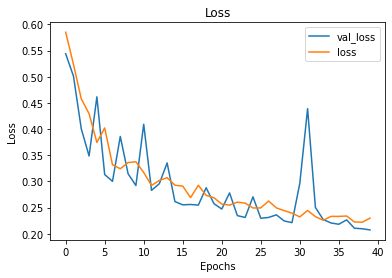

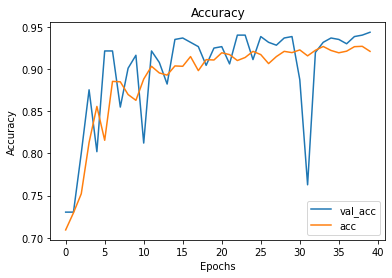

In [69]:
visualize_training_results(histoire)

In [70]:
preds_baseline = baseline.predict(test_img)

In [71]:
type(preds_baseline)

numpy.ndarray

In [72]:
preds_baseline.shape

(585, 1)

In [73]:
test_y.shape

(585, 1)

In [74]:
pred_baseline_class = baseline.predict_classes(test_img)

In [75]:
pred_baseline_class.shape

(585, 1)

In [76]:
pred_baseline_binary_class = (baseline.predict(test_img) > 0.5).astype("int32")
pred_baseline_binary_class.shape

(585, 1)

In [77]:
# test set
true_classes_baseline = test_generator.classes
print(true_classes_baseline)
class_labels_baseline = list(test_generator.class_indices.keys())
class_labels_baseline

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

['NORMAL', 'PNEUMONIA']

In [78]:
accuracy_baseline = accuracy_score(test_y, preds_baseline.round())
accuracy_baseline

0.9538461538461539

In [79]:
precision_baseline = precision_score(test_y, preds_baseline.round())
precision_baseline

0.896969696969697

In [80]:
recall_baseline = recall_score(test_y, preds_baseline.round())
recall_baseline

0.9367088607594937

In [81]:
f1_baseline = f1_score(test_y, preds_baseline.round())
f1_baseline

0.9164086687306501

In [82]:
auc_value_baseline = roc_auc_score(test_y, preds_baseline)
auc_value_baseline

0.9807606794533543

In [83]:
fpr_baseline, tpr_baseline, threshold_baseline = roc_curve(test_y, preds_baseline)

In [85]:
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

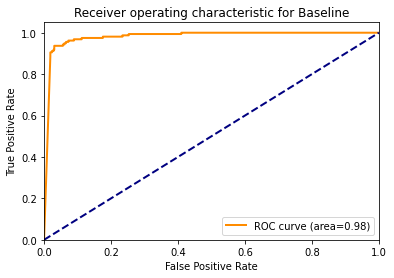

In [86]:
plt.figure()
lw=2
plt.plot(fpr_baseline, tpr_baseline, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value_baseline)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Baseline')
plt.legend(loc='lower right')
plt.show()

In [87]:
report_baseline = classification_report(test_y, preds_baseline.round(), target_names=class_labels_baseline)
print(report_baseline)

              precision    recall  f1-score   support

      NORMAL       0.98      0.96      0.97       427
   PNEUMONIA       0.90      0.94      0.92       158

    accuracy                           0.95       585
   macro avg       0.94      0.95      0.94       585
weighted avg       0.95      0.95      0.95       585



In [88]:
cnf_matrix_baseline = confusion_matrix(y_true=test_y, y_pred=preds_baseline.round())
np.set_printoptions(precision=2)
print(cnf_matrix_baseline)

[[410  17]
 [ 10 148]]


In [89]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [90]:
cm_plot_labels = ['NORMAL','PNEUMONIA']

Confusion matrix, without normalization
[[410  17]
 [ 10 148]]


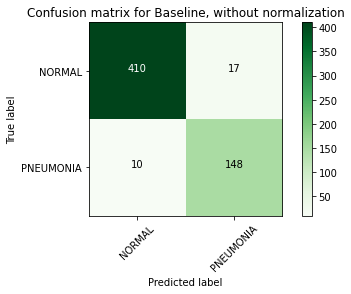

In [91]:
plt.figure()
plot_confusion_matrix(cnf_matrix_baseline, classes=cm_plot_labels, title='Confusion matrix for Baseline, without normalization')
plt.show()

Normalized confusion matrix
[[0.96 0.04]
 [0.06 0.94]]


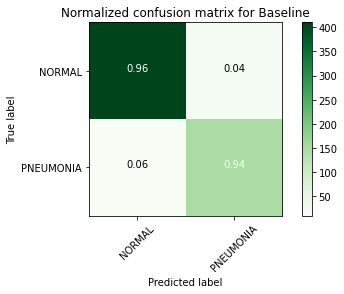

In [92]:
plt.figure()
plot_confusion_matrix(cnf_matrix_baseline, classes=cm_plot_labels, normalize=True, title='Normalized confusion matrix for Baseline')
plt.show()